In [4]:
import torch
import os, glob
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from tqdm import tqdm
from torch.nn import CrossEntropyLoss
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import torch
import os
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from tqdm import tqdm
from torch.nn import CrossEntropyLoss
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
import time
import argparse
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 如果使用多張 GPU

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(4)

# ----------------------
# (1) Model
# ----------------------
class SelfAttentionClassifier(nn.Module):
    def __init__(self, input_dim=25, seq_len=110, num_classes=2, d_model=128, nhead=8, num_layers=2, dim_feedforward=256, dropout=0.1):
        super(SelfAttentionClassifier, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)  # 將每一個時間點的特徵投影到 d_model 維度
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))  # 類似於 BERT 的 [CLS] token
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        B, T, C = x.shape  # B: batch size, T: sequence length, C: input_dim
        x = self.input_proj(x)  # [B, T, d_model]

        # 加入 [CLS] token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, d_model]
        x = torch.cat((cls_tokens, x), dim=1)  # [B, T+1, d_model]

        x = self.transformer_encoder(x)  # [B, T+1, d_model]
        cls_output = x[:, 0, :]  # 取出 [CLS] token 的輸出作為分類依據
        cls_output = self.dropout(cls_output)
        logits = self.fc(cls_output)
        return logits

class LSTMModel(nn.Module):
    def __init__(self, input_dim=25, hidden_dim=128, num_layers=2, num_classes=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)  # 單向 LSTM 輸出 hidden_dim
        
    def forward(self, x):
        _, (hn, _) = self.lstm(x)  # 只取最後一層的 hidden state
        out = self.fc(hn[-1])  # 使用最後一層的 hidden state 作為輸入
        return out
    
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim=25, hidden_dim=128, num_layers=2, num_classes=2):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # Bi-LSTM 輸出是 2 倍 hidden_dim
        
    def forward(self, x):
        _, (hn, _) = self.bilstm(x)
        out = self.fc(torch.cat((hn[-2], hn[-1]), dim=1))  # 拼接正向與反向 hidden state
        return out
    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=False):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding=kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        self.shortcut = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        
    def forward(self, x):
        identity = self.shortcut(x)  # 短路連接
        out = self.conv1(x)
        out = self.bn1(out)
        out = torch.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + identity  # 殘差連接
        out = torch.relu(out)
        return out

class ResNet32(nn.Module):
    def __init__(self, input_dim=25, num_classes=2):
        super(ResNet32, self).__init__()
        self.initial = nn.Conv1d(input_dim, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()

        # ResNet-32 主要包含 5 個 Block（共 32 層）
        self.layer1 = self.make_layer(64, 64, 5)
        self.layer2 = self.make_layer(64, 128, 5, downsample=True)
        self.layer3 = self.make_layer(128, 256, 5, downsample=True)
        self.layer4 = self.make_layer(256, 512, 5, downsample=True)
        
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # 壓縮時間維度
        self.fc = nn.Linear(512, num_classes)  # 最終分類

    def make_layer(self, in_channels, out_channels, num_blocks, downsample=False):
        layers = [ResidualBlock(in_channels, out_channels, downsample=downsample)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.initial(x)
        x = self.bn(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.global_avg_pool(x)  # [batch, channels, 1]
        x = x.squeeze(-1)  # 去掉最後的 1 維
        x = self.fc(x)  # 最終分類
        return x


# ----------------------
# (2) Custom Dataset
# ----------------------
class SkeletonDataset(Dataset):
    def __init__(self, datasets):
        self.features = []
        self.labels = []
        categories = glob.glob(os.path.join(datasets, '*'))
        
        for category in categories:
            recordings = glob.glob(os.path.join(category, '*'))
            for recording in recordings:
                delta_path = os.path.join(recording, 'filtered_delta_norm')
                delta2_path = os.path.join(recording, 'filtered_delta2_norm')
                zscore_path = os.path.join(recording, 'filtered_zscore_norm')
                delta_square_path = os.path.join(recording, 'filtered_delta_square_norm')
                filtered_path = os.path.join(recording, 'filtered_norm')
                
                if not all(map(os.path.exists, [delta_path, delta2_path, zscore_path, delta_square_path, filtered_path])):
                    print(f"Missing data in {recording}")
                    continue
                
                deltas = glob.glob(os.path.join(delta_path, '*.txt'))
                delta2s = glob.glob(os.path.join(delta2_path, '*.txt'))
                zscores = glob.glob(os.path.join(zscore_path, '*.txt'))
                delta_square = glob.glob(os.path.join(delta_square_path, '*.txt'))
                filtered = glob.glob(os.path.join(filtered_path, '*.txt'))
                
                data_per_ind = list(self.fetch(zip(deltas, delta2s, zscores,delta_square,filtered)))  # Ensure list output
                self.features.extend(data_per_ind)
                self.labels.extend([1 if 'Category_2' in category else 0] * len(data_per_ind))
    
    def fetch(self, uds):
        data_per_ind = []
        for ud in uds:
            parsed_data = []
            for file in ud:
                with open(file, 'r') as f:
                    lines = f.read().strip().split('\n')
                    parsed_data.append([list(map(float, line.split(','))) for line in lines])
            
            for num in zip(*parsed_data):
                data_per_ind.append([item for sublist in num for item in sublist])
                if len(data_per_ind) == 110:
                    yield data_per_ind
                    data_per_ind = []

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# ----------------------
# (3) Training Function
# ----------------------
# 計算 F1-score 的函數
def compute_f1_score(model, data_loader):
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return f1_score(y_true, y_pred, average="macro")  # 使用 Macro F1-score

def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, save_path, num_epochs=50, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_f1 = 0.0  # 用來儲存最佳 F1-score
    patience_counter = 0

    # **存放訓練過程的數據**
    train_losses = []
    train_f1_scores = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        y_true, y_pred = [], []

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

        avg_loss = total_loss / len(train_loader)
        train_f1 = f1_score(y_true, y_pred, average="macro")
        val_f1 = compute_f1_score(model, valid_loader)

        scheduler.step()
        print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

        # **紀錄數據**
        train_losses.append(avg_loss)
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        # 根據 F1-score 儲存最佳模型
        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print("✅ Model Saved (Best F1-score)")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹️ Early Stopping Triggered")
                break

    # **繪製 Loss 和 F1-score**
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(train_losses) + 1)
    
    plt.plot(epochs, train_losses, label="Train Loss", color='blue', marker='o')
    plt.plot(epochs, train_f1_scores, label="Train F1-score", color='green', marker='s')
    plt.plot(epochs, val_f1_scores, label="Validation F1-score", color='red', marker='d')

    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.title("Training Loss & F1-score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.savefig("./models/BiLSTM_train_results.png", dpi=300, bbox_inches="tight")  # 儲存高解析度圖片

# ----------------------
# (4) Validation Function
# ----------------------
def validate_model(model, valid_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(valid_loader)

# ----------------------
# (5) Testing Function
# ----------------------
def test_model(model, test_loader, criterion, save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(save_path))
    model.to(device)
    model.eval()
    
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    print(f"Test Loss: {total_loss / len(test_loader):.4f}, Accuracy: {correct / total * 100:.2f}%")

# ----------------------
# (6) Main Execution
# ----------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    datasets_path = os.path.join(os.getcwd(), 'datasets')
    full_dataset = SkeletonDataset(datasets_path)
    save_path="./models/ResNet32_model1.pth"
    
    train_size = int(0.75 * len(full_dataset))
    valid_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - valid_size
    
    # 計算每個類別的權重 (1 / 類別數量)
    train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])
    train_labels = [full_dataset.labels[i] for i in train_dataset.indices]  # 提取訓練集的標籤
    batch_size = 8
    num_samples = [sum(y == i for y in full_dataset.labels) for i in range(2)]
    class_weights = [1.0 / num for num in num_samples]
    sample_weights = [class_weights[label] for label in train_labels]
    if len(sample_weights) == 0:
        raise ValueError("train_labels 是空的，請確認訓練資料是否正確切分或標註")

    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model = ResNet32()
    # model = SelfAttentionClassifier(input_dim=25, seq_len=110, num_classes=2)

    # 計算類別權重 (1 / 類別比例)
    P_ratio = 0.18
    class_counts = torch.tensor([P_ratio, 1 - P_ratio])  # [負類, 正類] 的比例
    weights = 1.0 / class_counts
    criterion = CrossEntropyLoss(weight=weights.to(device))  # 設定加權損失函數
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.75)
    
    train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, save_path)
    test_model(model, test_loader, criterion, save_path)


ZeroDivisionError: float division by zero

shap_values shape: (880, 25)
sample_data shape: (880, 25)


C:\Users\user\AppData\Local\Temp\ipykernel_18080\2434959442.py:41: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_flat, sample_data_flat , feature_names = feature_names , max_display=25)


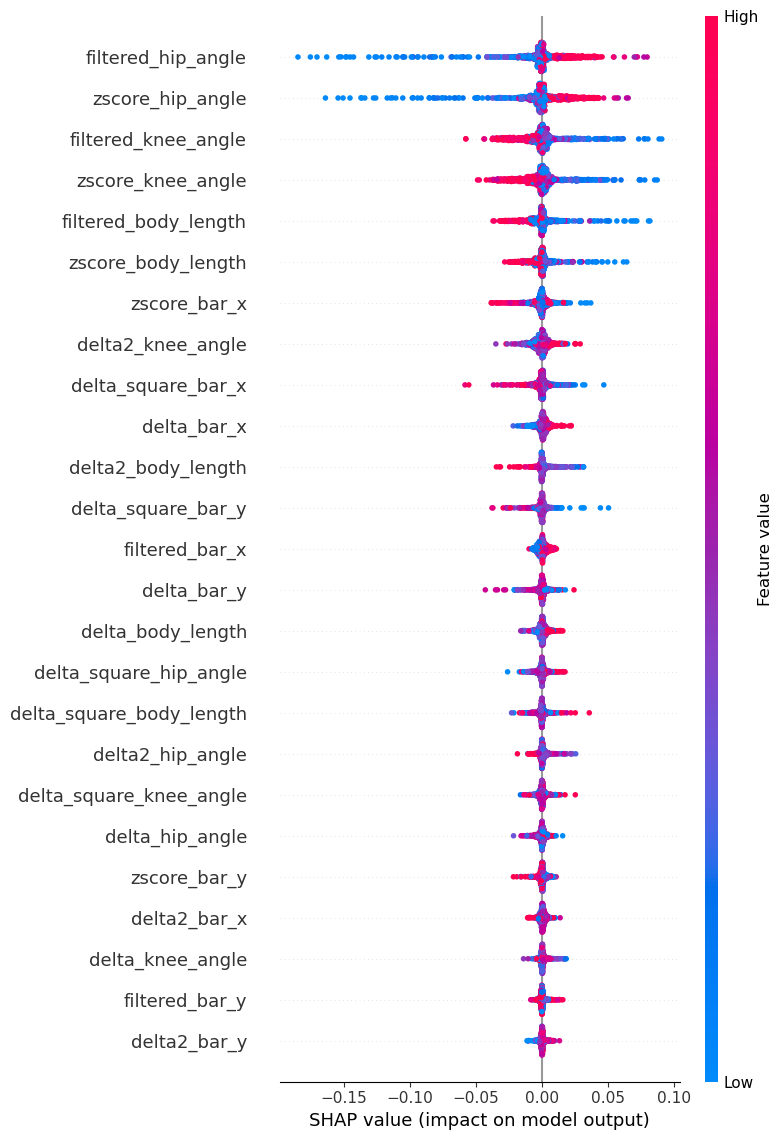

In [123]:
import shap
model.load_state_dict(torch.load("D:\\labdata\\MOCAP\\deadlift_system\\model_ana\\3\\ResNet32_model.pth"))
# model.load_state_dict(torch.load("D:\\labdata\\MOCAP\\deadlift_system\\models\\ResNet32_model1.pth"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# 取得部分測試數據（SHAP 計算通常只需要小部分數據）
sample_data, _ = next(iter(test_loader))
sample_data = sample_data.to(device)
# sample_data.requires_grad_()  # 讓 PyTorch 記錄 gradient 路徑

# 建立 Explainer
# explainer = shap.GradientExplainer(model, sample_data)
background = sample_data[:100]  # 隨便取一小部分當 baseline
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(sample_data, check_additivity=False)

# 計算 SHAP 值
# shap_values = explainer.shap_values(sample_data)
shap_values = shap_values[..., 0]  # 選擇第一個類別的 SHAP 值
# 視覺化 SHAP 值
# shap.summary_plot(shap_values, sample_data.cpu().numpy())


# 重新塑形 SHAP 值
shap_values_flat = shap_values.reshape(-1, 25)  # (8*110, 15)
sample_data_flat = sample_data.cpu().numpy().reshape(-1, 25)  # (8*110, 15)

print("shap_values shape:", shap_values_flat.shape)
print("sample_data shape:", sample_data_flat.shape)
feature_names = ["delta_hip_angle", "delta_knee_angle", "delta_body_length", "delta_bar_x",
                 "delta_bar_y", "delta2_hip_angle", "delta2_knee_angle", "delta2_body_length", "delta2_bar_x",
                 "delta2_bar_y", "zscore_hip_angle", "zscore_knee_angle", "zscore_body_length", "zscore_bar_x",
                 "zscore_bar_y","delta_square_hip_angle", "delta_square_knee_angle", "delta_square_body_length", "delta_square_bar_x",
                 "delta_square_bar_y","filtered_hip_angle", "filtered_knee_angle", "filtered_body_length", "filtered_bar_x",
                 "filtered_bar_y",]


# 正確繪製 SHAP summary plot
shap.summary_plot(shap_values_flat, sample_data_flat , feature_names = feature_names , max_display=25)








C:\Users\user\AppData\Local\Temp\ipykernel_18080\295590536.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_flat, sample_data_flat, plot_type="bar", feature_names =feature_names, max_display=25)


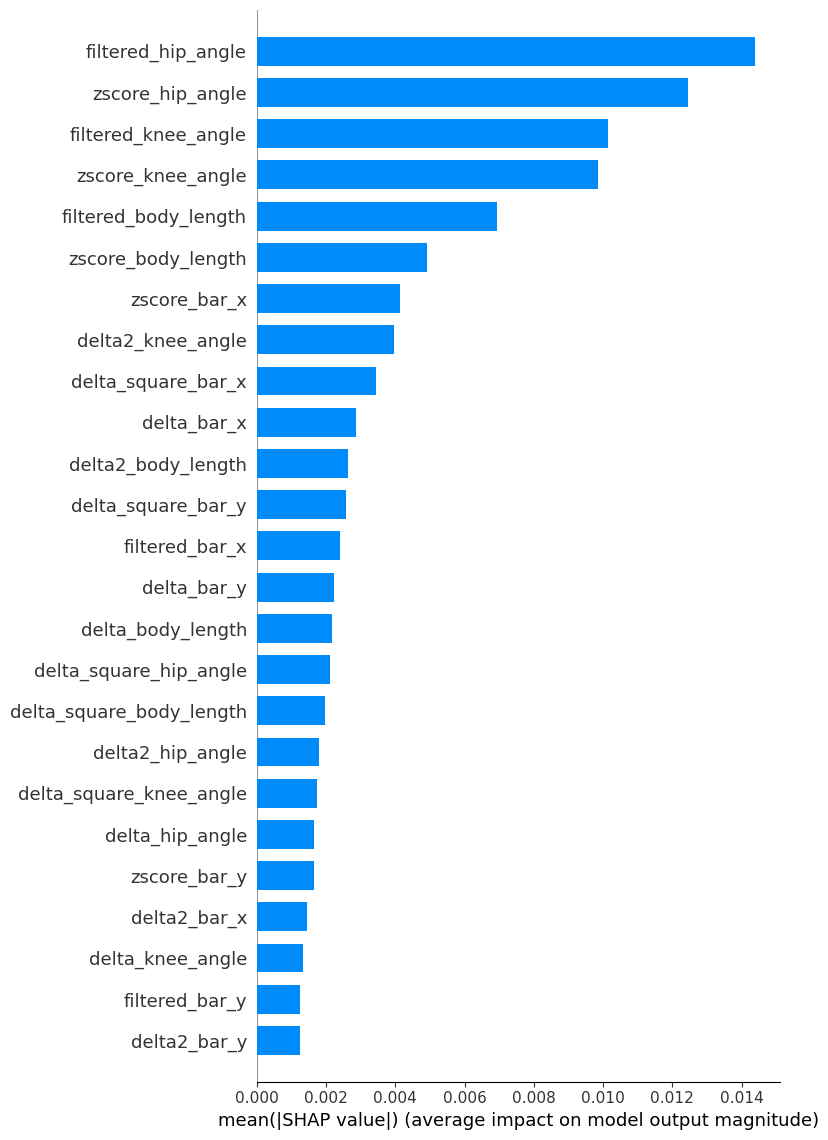

In [124]:
shap.summary_plot(shap_values_flat, sample_data_flat, plot_type="bar", feature_names =feature_names, max_display=25)



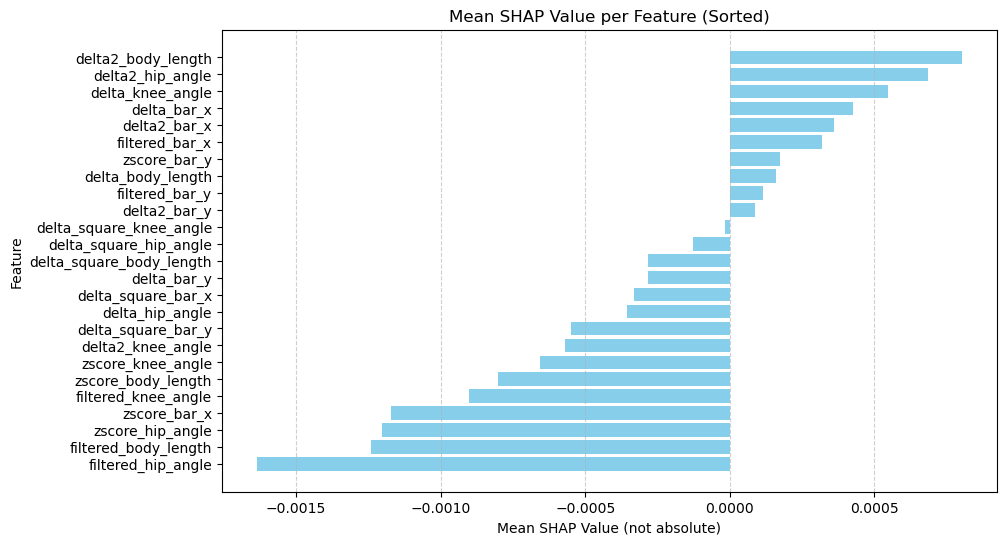

In [125]:
import numpy as np
import matplotlib.pyplot as plt

# 計算 SHAP 值的平均（不取絕對值）
shap_mean = np.mean(shap_values_flat, axis=0)  # shape = (25,)

# 依據 SHAP 值排序（從大到小）
sorted_indices = np.argsort(shap_mean)  # 由小到大排序
shap_mean_sorted = shap_mean[sorted_indices]
feature_names_sorted = [feature_names[i] for i in sorted_indices]

# 畫出 bar 圖
plt.figure(figsize=(10, 6))
plt.barh(feature_names_sorted, shap_mean_sorted, color='skyblue')
plt.xlabel("Mean SHAP Value (not absolute)")
plt.ylabel("Feature")
plt.title("Mean SHAP Value per Feature (Sorted)")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()


In [32]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from tqdm import tqdm
from torch.nn import CrossEntropyLoss
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
import time
import argparse
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 如果使用多張 GPU

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(4)

class TinyTransformer(nn.Module):
    def __init__(self, input_dim, seq_len=110, num_classes=2, d_model=64, nhead=4, num_layers=2):
        super(TinyTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)  # 轉換 25D 特徵為 d_model 維度
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, d_model))  # 加入 Positional Encoding

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=128, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)  # (batch, 110, 25) → (batch, 110, d_model)
        x += self.pos_embedding  # 加入 Positional Encoding
        x = self.transformer(x)  # Transformer Encoder
        x = x.mean(dim=1)  # 對時間步做 Global Pooling
        return self.fc(x)
    
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, num_classes=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)  # 單向 LSTM 輸出 hidden_dim
        
    def forward(self, x):
        _, (hn, _) = self.lstm(x)  # 只取最後一層的 hidden state
        out = self.fc(hn[-1])  # 使用最後一層的 hidden state 作為輸入
        return out
    
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, num_classes=2):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # Bi-LSTM 輸出是 2 倍 hidden_dim
        
    def forward(self, x):
        _, (hn, _) = self.bilstm(x)
        out = self.fc(torch.cat((hn[-2], hn[-1]), dim=1))  # 拼接正向與反向 hidden state
        return out
    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=False):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding=kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        self.shortcut = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        
    def forward(self, x):
        identity = self.shortcut(x)  # 短路連接
        out = self.conv1(x)
        out = self.bn1(out)
        out = torch.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity  # 殘差連接
        out = torch.relu(out)
        return out

class ResNet32(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(ResNet32, self).__init__()
        self.initial = nn.Conv1d(input_dim, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()

        # ResNet-32 主要包含 5 個 Block（共 32 層）
        self.layer1 = self.make_layer(64, 64, 5)
        self.layer2 = self.make_layer(64, 128, 5, downsample=True)
        self.layer3 = self.make_layer(128, 256, 5, downsample=True)
        self.layer4 = self.make_layer(256, 512, 5, downsample=True)
        
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)  # 壓縮時間維度
        self.fc = nn.Linear(512, num_classes)  # 最終分類

    def make_layer(self, in_channels, out_channels, num_blocks, downsample=False):
        layers = [ResidualBlock(in_channels, out_channels, downsample=downsample)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.initial(x)
        x = self.bn(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.global_avg_pool(x)  # [batch, channels, 1]
        x = x.squeeze(-1)  # 去掉最後的 1 維
        x = self.fc(x)  # 最終分類
        return x


# 計算 F1-score 的函數
def f1_score(y_true, y_pred):
    # Get unique classes
    classes = np.unique(np.concatenate((y_true, y_pred)))
    
    # Initialize
    class_f1_scores = {}
    class_weights = {}
    
    # Count instances of each class in true labels
    total_samples = len(y_true)
    class_counts = Counter(y_true)
    
    # Calculate weights for each class
    for cls in classes:
        class_weights[cls] = class_counts.get(cls, 0) / total_samples
    
    # For each class, calculate F1 score
    for cls in classes:
        # True positives, false positives, false negatives
        tp = np.sum((y_true == cls) & (y_pred == cls) & ~((y_true == 0) & (y_pred == 0)))
        fp = np.sum((y_true != cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))
        
        # Precision and recall
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # F1 score for this class
        if precision + recall > 0:
            class_f1_scores[cls] = 2 * (precision * recall) / (precision + recall)
        else:
            class_f1_scores[cls] = 0
    
    # Calculate weighted F1 score
    weighted_f1 = sum(class_weights[cls] * class_f1_scores[cls] for cls in classes)
    return weighted_f1

def compute_f1_score(model, data_loader):
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for inputs, labels, indices in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return f1_score(y_true, y_pred)  

def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, save_path, fig_path, num_epochs=100, patience=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_f1 = 0.0  # 用來儲存最佳 F1-score
    patience_counter = 0

    # **存放訓練過程的數據**
    train_losses = []
    train_f1_scores = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        y_true, y_pred = [], []

        for inputs, labels, indices in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

        avg_loss = total_loss / len(train_loader)
        train_f1 = f1_score(y_true, y_pred)
        val_f1 = compute_f1_score(model, valid_loader)

        scheduler.step()
        print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

        # **紀錄數據**
        train_losses.append(avg_loss)
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        # 根據 F1-score 儲存最佳模型
        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print("✅ Model Saved (Best F1-score)")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹️ Early Stopping Triggered")
                break

    # **繪製 Loss 和 F1-score**
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(train_losses) + 1)
    
    plt.plot(epochs, train_losses, label="Train Loss", color='blue', marker='o')
    plt.plot(epochs, train_f1_scores, label="Train F1-score", color='green', marker='s')
    plt.plot(epochs, val_f1_scores, label="Validation F1-score", color='red', marker='d')

    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.title("Training Loss & F1-score per Epoch")
    plt.legend()
    plt.grid(True)
    plt.savefig(fig_path, dpi=300, bbox_inches="tight")  # 儲存高解析度圖片

# ----------------------
# Validation Function
# ----------------------
def validate_model(model, valid_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels, indices in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(valid_loader)

# ----------------------
# Testing Function
# ----------------------
def test_model_with_path_tracking(model, test_loader, test_dataset, criterion, save_dir, save_path, full_dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(save_path))
    model.to(device)
    model.eval()
    
    total_loss, total_time = 0.0, 0.0  
    y_true, y_pred = [], []

    false_positives = []
    false_negatives = []
    
    with torch.no_grad():
        for inputs, labels, indices in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            start_time = time.time()
            outputs = model(inputs)
            end_time = time.time()
            total_time += (end_time - start_time)

            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            for i in range(len(inputs)):  # 只迭代當前批次中的實際樣本數量
                sample_idx = indices[i].item()  # 直接拿到 full_dataset index！
                detailed_path = full_dataset.get_sample_path(sample_idx)
                
                if predicted[i] == 1 and labels[i] == 0:
                    false_positives.append(f"{str(detailed_path)}")
                elif predicted[i] == 0 and labels[i] == 1:
                    false_negatives.append(f"{str(detailed_path)}")
                    
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    avg_time_per_sample = total_time / len(y_true)
    f1 = f1_score(y_true, y_pred) 

    model_name = os.path.splitext(os.path.basename(save_path))[0]
    txt_dir = os.path.join(save_dir, f"{model_name}_results")
    os.makedirs(txt_dir, exist_ok=True)

    with open(f"{txt_dir}/false_positives.txt", "w") as fp_file:
        fp_file.write("\n".join(false_positives))
    
    with open(f"{txt_dir}/false_negatives.txt", "w") as fn_file:
        fn_file.write("\n".join(false_negatives))
        
    print(f"共有 {len(false_positives)} FP，{len(false_negatives)} FN")
    print(f"已保存到 {txt_dir}/false_positives.txt 和 false_negatives.txt")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(6, 6))
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.savefig(f"{txt_dir}/confusion_matrix.png")
    plt.close()

    return avg_loss, f1, avg_time_per_sample, false_positives, false_negatives

                                     
# ----------------------
# (6) Main Execution
# ----------------------
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--GT_class',type=str)
    parser.add_argument('--Input_dim',type=int)
    args = parser.parse_args()
    GT_class = args.GT_class
    input_dim = args.Input_dim
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    datasets_path = os.path.join(os.getcwd(), 'dataset')
    
    if input_dim == 25:
        from dataset import Dataset_25f
        full_dataset = Dataset_25f(datasets_path, GT_class)
        
    elif input_dim == 19:
        from dataset import Dataset_19f
        full_dataset = Dataset_19f(datasets_path, GT_class)
        
    save_dir = f'./models_{input_dim}/{GT_class}'
    
    category_ratio = {'1': 0.18, '2': 0.28, '3': 0.19, '4': 0.18, '5': 0.27}
    train_size = int(0.75 * len(full_dataset))
    valid_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - valid_size
    
    # 計算每個類別的權重 (1 / 類別數量)
    train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])
    train_labels = [full_dataset.labels[i] for i in train_dataset.indices]  # 提取訓練集的標籤
    batch_size = 8
    num_samples = [sum(y == i for y in full_dataset.labels) for i in range(2)]
    class_weights = [1.0 / num for num in num_samples]
    sample_weights = [class_weights[label] for label in train_labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    Los = []
    Accs = []
    Inf_times = []
#     models = {'BiLSTM': BiLSTMModel(input_dim), 'ResNet32': ResNet32(input_dim), 'TinyTransformer': TinyTransformer(input_dim)}
    models = {'ResNet32': ResNet32(input_dim)}
    
    for model_str, model in models.items():
        # 計算類別權重 (1 / 類別比例)
        P_ratio = category_ratio[GT_class]
        class_counts = torch.tensor([P_ratio, 1 - P_ratio])  # [負類, 正類] 的比例
        weights = 1.0 / class_counts
        criterion = CrossEntropyLoss(weight=weights.to(device))  # 設定加權損失函數
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
        save_path = os.path.join(save_dir, f"{model_str}_model.pth")
        fig_path = os.path.join(save_dir, f"{model_str}_train_results.png")
        train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, save_path, fig_path)
        avg_loss, f1, avg_time_per_sample, false_positives, false_negatives = test_model_with_path_tracking(model, test_loader, test_dataset, criterion, save_dir, save_path, full_dataset)

        Los.append(avg_loss)
        Accs.append(f1)  # 注意：這裡變成 F1 分數
        Inf_times.append(avg_time_per_sample)
        print(f'{model_str}_model is completely trained.')
    
    for i, (model, f_m) in enumerate(models.items()):
        print(f"{model} Test Loss: {Los[i]}, F1 Score: {Accs[i]:.4f}, Avg Inference Time per Sample: {Inf_times[i]:.6f} sec")

usage: ipykernel_launcher.py [-h] [--GT_class GT_CLASS] [--Input_dim INPUT_DIM]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\user\AppData\Roaming\jupyter\runtime\kernel-eb5d20cf-ad7a-48e5-8f81-e0ca8e79c6f2.json


SystemExit: 2

C:\Users\user\Anaconda3\envs\deadlift\lib\site-packages\IPython\core\interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


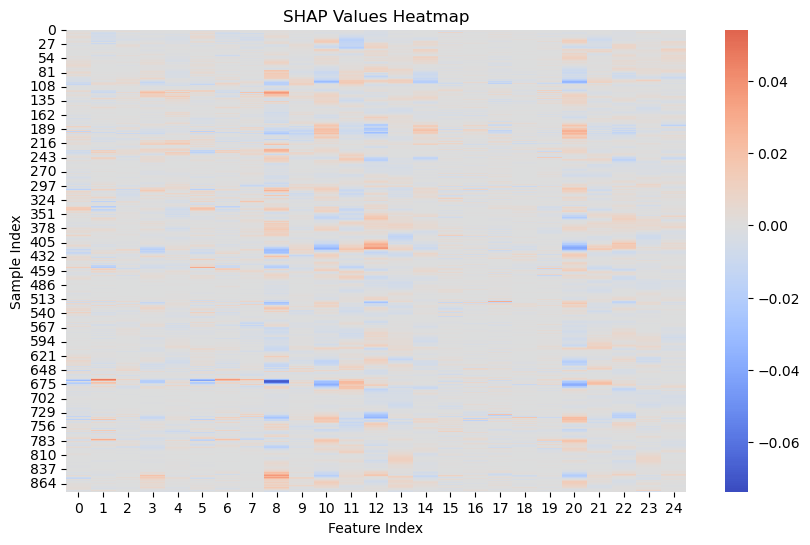

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(shap_values_flat, cmap="coolwarm", center=0)
plt.xlabel("Feature Index")
plt.ylabel("Sample Index")
plt.title("SHAP Values Heatmap")
plt.show()


In [80]:
import shap
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 取一小部分作為 baseline
model = model.to(device)
model.eval()

background = background.to(device)
background = sample_data[:10]
background.requires_grad_()

# 使用 DeepExplainer
explainer = shap.DeepExplainer(model, background)

# SHAP 計算
sample_data = sample_data.to(device)
sample_data = sample_data[:1]
sample_data.requires_grad_()
shap_values = explainer.shap_values(sample_data)

# 選擇模型預測類別
output = model(sample_data)
pred_class = torch.argmax(output, dim=1).cpu().numpy()
shap_values = np.array([shap_values[c][i] for i, c in enumerate(pred_class)])
feature_names = ["delta_hip_angle", "delta_knee_angle", "delta_body_length", "delta_bar_x",
                 "delta_bar_y", "delta2_hip_angle", "delta2_knee_angle", "delta2_body_length", "delta2_bar_x",
                 "delta2_bar_y", "zscore_hip_angle", "zscore_knee_angle", "zscore_body_length", "zscore_bar_x",
                 "zscore_bar_y","delta_square_hip_angle", "delta_square_knee_angle", "delta_square_body_length", "delta_square_bar_x",
                 "delta_square_bar_y","filtered_hip_angle", "filtered_knee_angle", "filtered_body_length", "filtered_bar_x",
                 "filtered_bar_y",]

# 繪圖
print("shap_values.shape:", np.array(shap_values).shape)
print("sample_data.shape:", sample_data.shape)

shap.summary_plot(shap_values, sample_data.cpu().detach().numpy(), feature_names=feature_names)



AssertionError: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 0.5072659913962525 - Tolerance: 0.01